In [1]:
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import openturns as ot
from itertools import product

# Q1 1/8 hours * 25 = 3.125 minutes

Loading the data and visualizing the total bookings per day. Firstly we may simply format and view the data.

Comments:
1. I notice date columns ["Booking date" and "Reservation date"] and format using `pd.to_datetime`
2. Reservation date >= Booking date
3. Can have multiple bookings for a Booking ID i.e. many-to-one.
4. "Rate plan type" can be only two values; "Miscellaneous" and "Group".

In [2]:
bookings_df = pd.read_csv('data/hotel_A_bookings.csv')
bookings_df['Booking date'] = pd.to_datetime(bookings_df['Booking date'])
bookings_df['Reservation date'] = pd.to_datetime(bookings_df['Reservation date'])
display(bookings_df)
display(bookings_df.dtypes)
display(bookings_df['Rate plan type'].unique())

Booking date                            Booking ID Reservation date  \
0       2019-12-31  6e2ab539-8940-4b77-ab17-ab3400e8558a       2019-12-31   
1       2019-12-31  78969040-c78e-4e6a-92b9-ab340126bfff       2019-12-31   
2       2019-12-30  5ebf260c-2b35-454a-aad8-ab3300ec1bf7       2019-12-31   
3       2019-12-30  638c3726-1084-4459-80c8-ab3300ad4817       2019-12-30   
4       2019-12-30  0ae71b20-28fd-41e6-a845-ab3300ee5030       2019-12-30   
...            ...                                   ...              ...   
44542   2018-01-23  137487b2-643a-437e-a665-c51859ba9542       2019-01-15   
44543   2018-01-23  72111848-3c88-49ea-bed5-175023845d42       2019-01-14   
44544   2018-01-23  04feae36-30f9-40ac-bf09-53b01a4bdc30       2019-01-16   
44545   2018-01-23  f5cc5891-f6a5-409e-9467-c37e859345a4       2019-01-14   
44546   2018-01-23  aaa4f7d0-37cc-47f6-8492-46077e6f340f       2019-01-15   

      Rate plan type  Number of rooms booked   Price  
0      Miscellaneous                       1   51.64  
1      Miscellaneous                       1   66.60  
2      Miscellaneous                       1   66.60  
3      Miscellaneous                       1   42.30  
4      Miscellaneous                       1   41.90  
...              ...                     ...     ...  
44542          Group                       1  105.00  
44543          Group                       1  105.00  
44544          Group                       1   87.48  
44545          Group                       1  105.00  
44546          Group                       1  105.00  

[44547 rows x 6 columns]

Booking date              datetime64[ns]
Booking ID                        object
Reservation date          datetime64[ns]
Rate plan type                    object
Number of rooms booked             int64
Price                            float64
dtype: object

array(['Miscellaneous', 'Group'], dtype=object)

In [3]:
# Obersiving that a single booking may make multiple bookings to reserve for
# multiple dates.
bookings_id_counts = bookings_df.groupby('Booking ID')['Booking ID'].count()
more_than_one_booking = bookings_id_counts.index[bookings_id_counts > 1]
bookings_df.loc[bookings_df['Booking ID'].isin(more_than_one_booking)].sort_values('Booking ID')

Booking date                            Booking ID Reservation date  \
26055   2019-05-01  0004e59b-06ea-4862-b666-aa40000903df       2019-05-12   
26095   2019-05-01  0004e59b-06ea-4862-b666-aa40000903df       2019-05-11   
26143   2019-05-01  0004e59b-06ea-4862-b666-aa40000903df       2019-05-13   
25650   2019-05-04  00051d3b-6b77-4dd6-8246-aa43014e4e25       2019-05-09   
25600   2019-05-04  00051d3b-6b77-4dd6-8246-aa43014e4e25       2019-05-10   
...            ...                                   ...              ...   
43826   2018-08-21  fffc3852-e191-4c08-8f1a-d3bbda1907aa       2019-03-14   
43825   2018-08-21  fffc3852-e191-4c08-8f1a-d3bbda1907aa       2019-03-13   
43800   2018-08-21  fffc3852-e191-4c08-8f1a-d3bbda1907aa       2019-03-12   
14918   2019-07-23  ffffd14a-d995-4527-8362-aa9300d920dd       2019-07-23   
14969   2019-07-23  ffffd14a-d995-4527-8362-aa9300d920dd       2019-07-24   

      Rate plan type  Number of rooms booked  Price  
26055  Miscellaneous                       1  17.82  
26095  Miscellaneous                       1  27.54  
26143  Miscellaneous                       1  17.82  
25650  Miscellaneous                       1  22.50  
25600  Miscellaneous                       1  30.20  
...              ...                     ...    ...  
43826          Group                       1  99.00  
43825          Group                       1  81.00  
43800          Group                       1  81.00  
14918  Miscellaneous                       1  26.60  
14969  Miscellaneous                       1  26.60  

[39323 rows x 6 columns]

In [4]:
# checking nulls
display(bookings_df.isnull().sum())

Booking date              0
Booking ID                0
Reservation date          0
Rate plan type            0
Number of rooms booked    0
Price                     0
dtype: int64

In [5]:
# checking booking id unique ratio
display(len(bookings_df['Booking ID'].unique())/len(bookings_df['Booking ID']))

0.39486385166228927

In [6]:
# "Compute the final number of bookings for each night in the data."
# Rolling count is added as a basic view of trend.
bookings_per_day = bookings_df.groupby('Reservation date')['Reservation date'].count()
bookings_per_day = pd.DataFrame(bookings_per_day).rename(columns={'Reservation date': 'Booking count'})
bookings_per_day = bookings_per_day.reset_index()
bookings_per_day['7 day rolling mean'] = bookings_per_day.rolling(7)['Booking count'].mean()
bookings_per_day['30 day rolling mean'] = bookings_per_day.rolling(30)['Booking count'].mean()

In [7]:
# Checking any gaps in data
bookings_per_day['date diff'] = bookings_per_day['Reservation date'].diff()
display(bookings_per_day[['Reservation date', 'date diff']].loc[bookings_per_day['date diff'] != pd.Timedelta(days=1)])
bookings_per_day = bookings_per_day.drop(columns=['date diff'])

Reservation date date diff
0       2019-01-01       NaT

count    638.000000
mean      69.822884
std       64.311143
min        1.000000
25%        7.000000
50%       59.000000
75%      124.000000
max      229.000000
Name: Booking count, dtype: float64

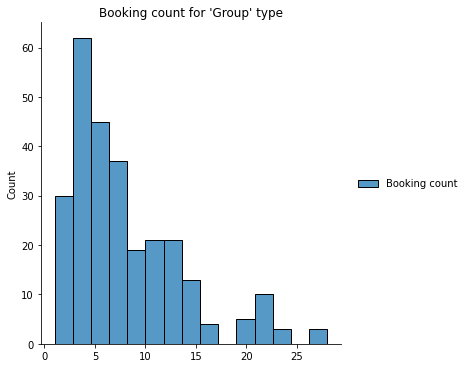

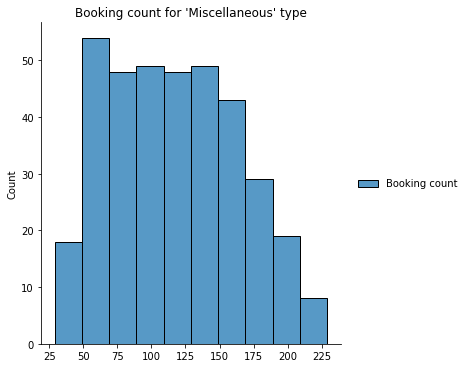

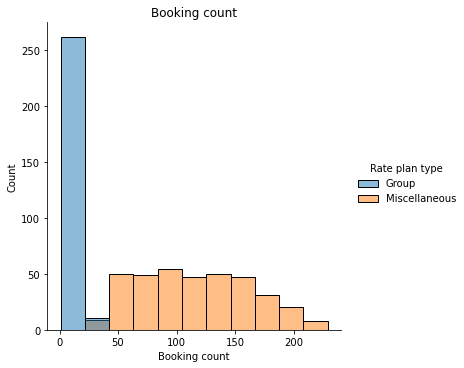

In [8]:
# Checking distribution of booking counts
bookings_by_plan = bookings_df.groupby(['Reservation date', 'Rate plan type'], as_index=False)['Booking date'].count()
bookings_by_plan = bookings_by_plan.rename(columns={'Booking date': 'Booking count'})
sns.displot(bookings_by_plan.loc[bookings_by_plan['Rate plan type'] == 'Group'])
plt.title("Booking count for 'Group' type")
sns.displot(bookings_by_plan.loc[bookings_by_plan['Rate plan type'] == 'Miscellaneous'])
plt.title("Booking count for 'Miscellaneous' type")
sns.displot(bookings_by_plan, x='Booking count', hue='Rate plan type')
plt.title("Booking count")
display(bookings_by_plan['Booking count'].describe())

Histogram of number of bookings in a day of the different rate plan types.

1. There are much less "Group" bookings
2. Mean number of bookings is 69.8

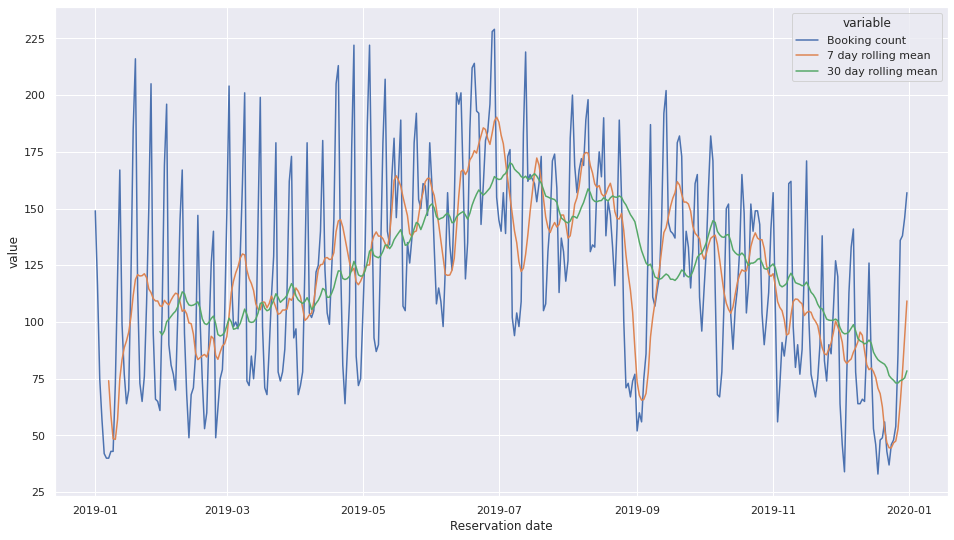

<AxesSubplot:xlabel='Reservation date', ylabel='value'>

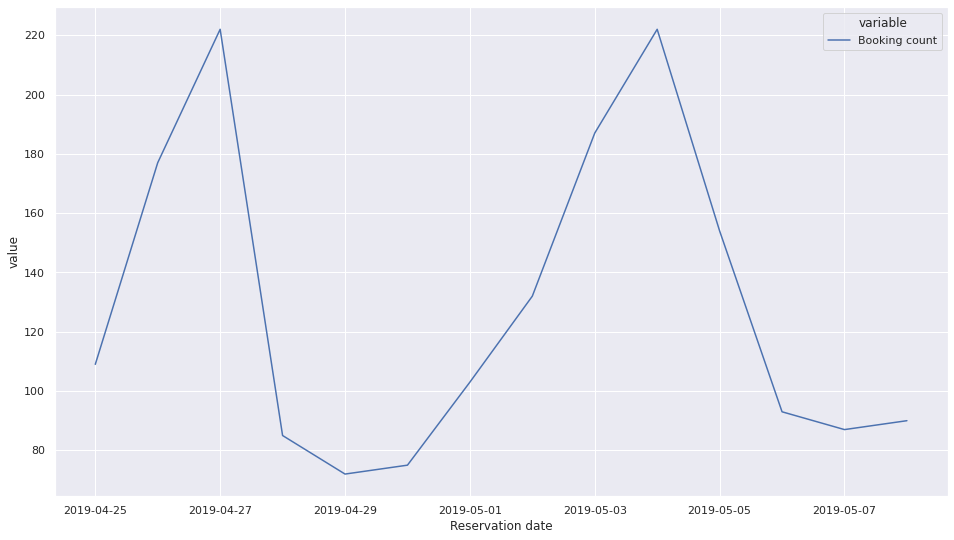

In [9]:
# Line plot
plot_df = bookings_per_day.melt(['Reservation date'])
sns.set(rc={'figure.figsize':(16, 9)})
sns.lineplot(data=plot_df, x='Reservation date', y='value', hue='variable')
plt.show()
sns.set(rc={'figure.figsize':(16, 9)})
sns.lineplot(data=plot_df.iloc[114:128, :], x='Reservation date', y='value', hue='variable')

In [10]:
print('Summary of counts')
display(bookings_per_day['Booking count'].describe())
print('Summary of counts "Reservation date" < 2019-06-01')
display(bookings_per_day.loc[bookings_per_day['Reservation date'] < datetime.datetime(2019, 6, 1)]['Booking count'].describe())
print('Summary of counts "Reservation date" >= 2019-06-01')
display(bookings_per_day.loc[bookings_per_day['Reservation date'] >= datetime.datetime(2019, 6, 1)]['Booking count'].describe())


Summary of counts


count    365.000000
mean     122.046575
std       45.272078
min       33.000000
25%       85.000000
50%      120.000000
75%      157.000000
max      229.000000
Name: Booking count, dtype: float64

Summary of counts "Reservation date" < 2019-06-01


count    151.000000
mean     116.033113
std       46.253853
min       40.000000
25%       76.500000
50%      105.000000
75%      148.500000
max      222.000000
Name: Booking count, dtype: float64

Summary of counts "Reservation date" >= 2019-06-01


count    214.000000
mean     126.289720
std       44.183465
min       33.000000
25%       90.250000
50%      131.500000
75%      160.000000
max      229.000000
Name: Booking count, dtype: float64

In [11]:
# Summary statistics grouping by day of week. (0 is Monday, 6 is Sunday)
bookings_per_day['Reservation dow'] = bookings_per_day['Reservation date'].dt.dayofweek
bookings_per_day.groupby('Reservation dow')['Booking count'].describe()

count        mean        std   min     25%    50%     75%  \
Reservation dow                                                              
0                 52.0   97.480769  33.742677  37.0   72.00   93.5  125.75   
1                 53.0  102.264151  40.728534  34.0   68.00   99.0  135.00   
2                 52.0  106.538462  41.787258  33.0   75.00   97.5  131.50   
3                 52.0  120.192308  37.660006  48.0   94.75  115.0  145.00   
4                 52.0  150.788462  38.271136  49.0  128.50  161.0  179.00   
5                 52.0  169.576923  39.633293  42.0  151.00  173.0  198.25   
6                 52.0  107.865385  31.255449  40.0   92.25  104.5  131.50   

                   max  
Reservation dow         
0                165.0  
1                185.0  
2                212.0  
3                214.0  
4                228.0  
5                229.0  
6                169.0

In [12]:
# Observing if mean price correlates with booking counts
bookings_df['Reservation date dow'] = bookings_df['Reservation date'].dt.dayofweek
bookings_df_dow = bookings_df.groupby('Reservation date dow').agg({'Booking ID': 'count', 'Price': 'mean'})
bookings_df_dow = bookings_df_dow.rename(columns={'Booking ID': 'Booking count'})
display(bookings_df_dow)
display(bookings_df_dow.corr())

Booking count      Price
Reservation date dow                          
0                              5069  33.888810
1                              5420  35.192598
2                              5540  33.549513
3                              6250  33.255682
4                              7841  33.636637
5                              8818  36.958366
6                              5609  28.430859

Booking count     Price
Booking count       1.000000  0.469838
Price               0.469838  1.000000

1. Notice clear seasonality at daily scale
2. Rolling average show potential seasonality at monthly scale, higher counts for months around 2019-07
2. Large dip occurs for a period near "2019-09"
3. Earlier months have more variance than later months
4. Some correlation with price and booking count, which may suggest booking count is already used as part of pricing strategy.


### How might final bookings be related to demand?
We may interpret the final bookings number a part of sales for this this hotel, and in that view we can relate these numbers to demand in the same way we would sales. Demand may be seen as the consumer want and sales as consumer need. We may review and keep note of the properties of this data understanding that constraints such as; competitors, market changes, fully booked rooms would have affected our resulting final bookings number differently than it may demand.

### What might that tell us about general pricing strategies?
It should reasonable to assume that by law of demand[1] the demand will have an inverse relationship with price i.e. the as the price decreases the demand will increase. 
A very basic example. With the booking counts as above we may end up forecasting that for days Monday, Tuesday and Wednesday the demand will be lowest and to bring demand up we can reduce price for these days. Or inversely for the other days. Idea of being that the pricing should be reactive of demand.

[1]: https://en.wikipedia.org/wiki/Law_of_demand

# Q2 2.5/8 * 25 = 7.8125 mins

A model to describe the arrival over time of bookings for a night.

In [13]:
def log_over_zero(series):
    """ np.log for a pd.Series ignoring values <= 0
    """
    out = series.copy()
    out.loc[out > 0] = np.log(out.loc[out > 0])
    return out

count                         17590
mean     32 days 01:39:13.200682206
std      59 days 23:53:43.816737684
min               -1 days +00:00:00
25%                 3 days 00:00:00
50%                12 days 00:00:00
75%                32 days 00:00:00
90%                75 days 00:00:00
95%               137 days 00:00:00
99%               350 days 00:00:00
max               575 days 00:00:00
Name: Booking lead time, dtype: object

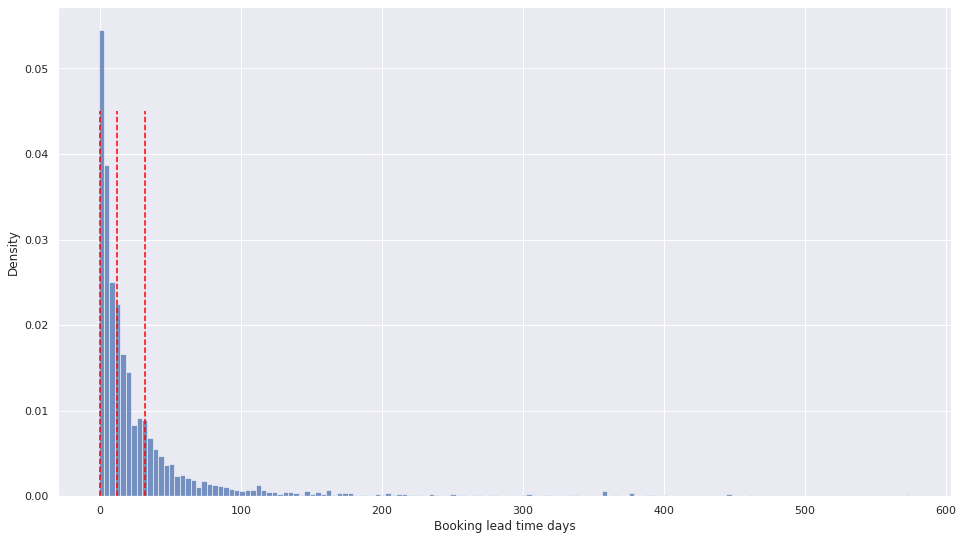

In [14]:
# generating lead time and plotting counts against lead time
lead_time_df = bookings_df.groupby(['Booking ID']).agg({'Booking date': 'min', 'Reservation date': 'max'})
lead_time_df['Booking lead time'] = lead_time_df['Reservation date'] - lead_time_df['Booking date']
lead_time_df['Booking lead time days'] = lead_time_df['Booking lead time'].dt.days
display(lead_time_df['Booking lead time'].describe(percentiles=[.25, .5, .75, 0.9, 0.95, 0.99]))
sns.histplot(lead_time_df['Booking lead time days'], stat='density', bins=150) # looks like pareto distriubtion
plt.vlines([lead_time_df['Booking lead time days'].mode()[0], lead_time_df['Booking lead time days'].median(), lead_time_df['Booking lead time days'].mean()],
           linestyles='dashed', ymin=0, ymax=0.045, colors=(1, 0, 0))
#sns.displot(log_over_zero(bookings_df['Booking lead time days']), height=9, aspect=1.6)

In [15]:
# aggregating booking counts by lead time days
fractional_bookings_by_lead_time = lead_time_df.groupby('Booking lead time days', as_index=False)['Booking date'].count()
fractional_bookings_by_lead_time = fractional_bookings_by_lead_time.rename(columns={'Booking date': 'Booking count'})
display(fractional_bookings_by_lead_time.head(20))

Booking lead time days  Booking count
0                       -1             85
1                        0           1356
2                        1           1277
3                        2            960
4                        3            810
5                        4            670
6                        5            608
7                        6            525
8                        7            473
9                        8            402
10                       9            417
11                      10            400
12                      11            395
13                      12            420
14                      13            351
15                      14            349
16                      15            267
17                      16            254
18                      17            315
19                      18            288

In [16]:
# fitting pareto distribution 
X = lead_time_df['Booking lead time days'].copy()
X_list = [[x] for x in X.tolist()]
sample = ot.Sample(X_list)
distribution = ot.ParetoFactory().buildMethodOfLeastSquares(sample)
print(distribution)
pdf_graph = distribution.drawPDF()
pdf_graph.setColors(['blue'])

Pareto(beta = 28.7259, alpha=1.77276, gamma=-30.6295)


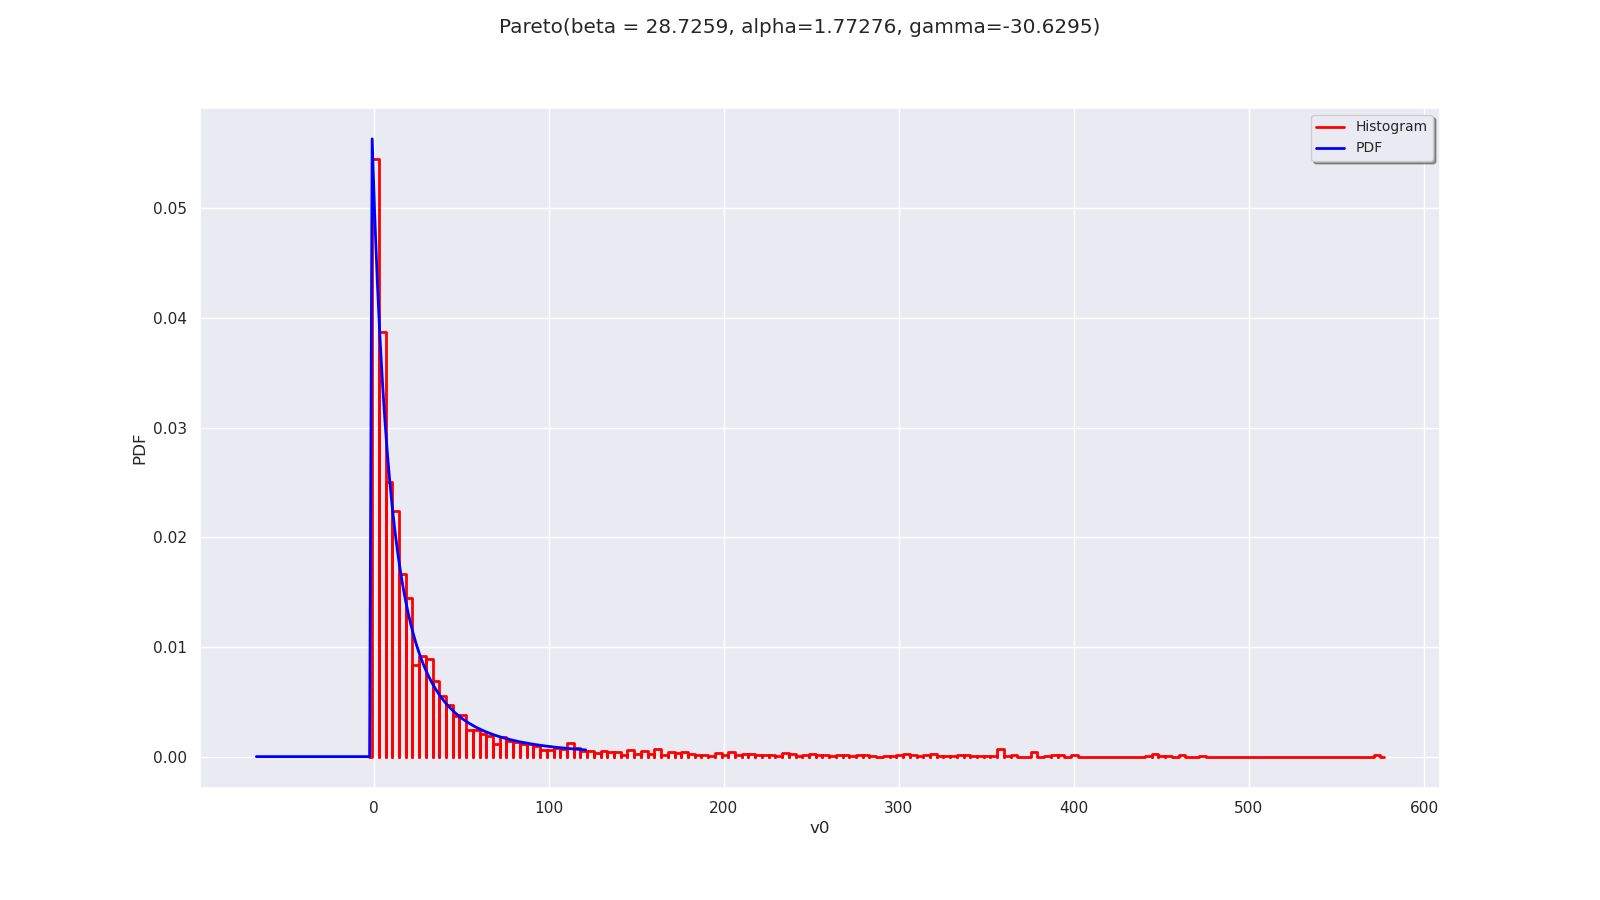

In [17]:
# plotting the estimated distribution over our histogram of samples
histo = ot.HistogramFactory().build(X_list, 150).drawPDF()
histo.add(pdf_graph)
histo.setLegends(["Histogram", 'PDF'])
histo.setTitle(str(distribution))
histo


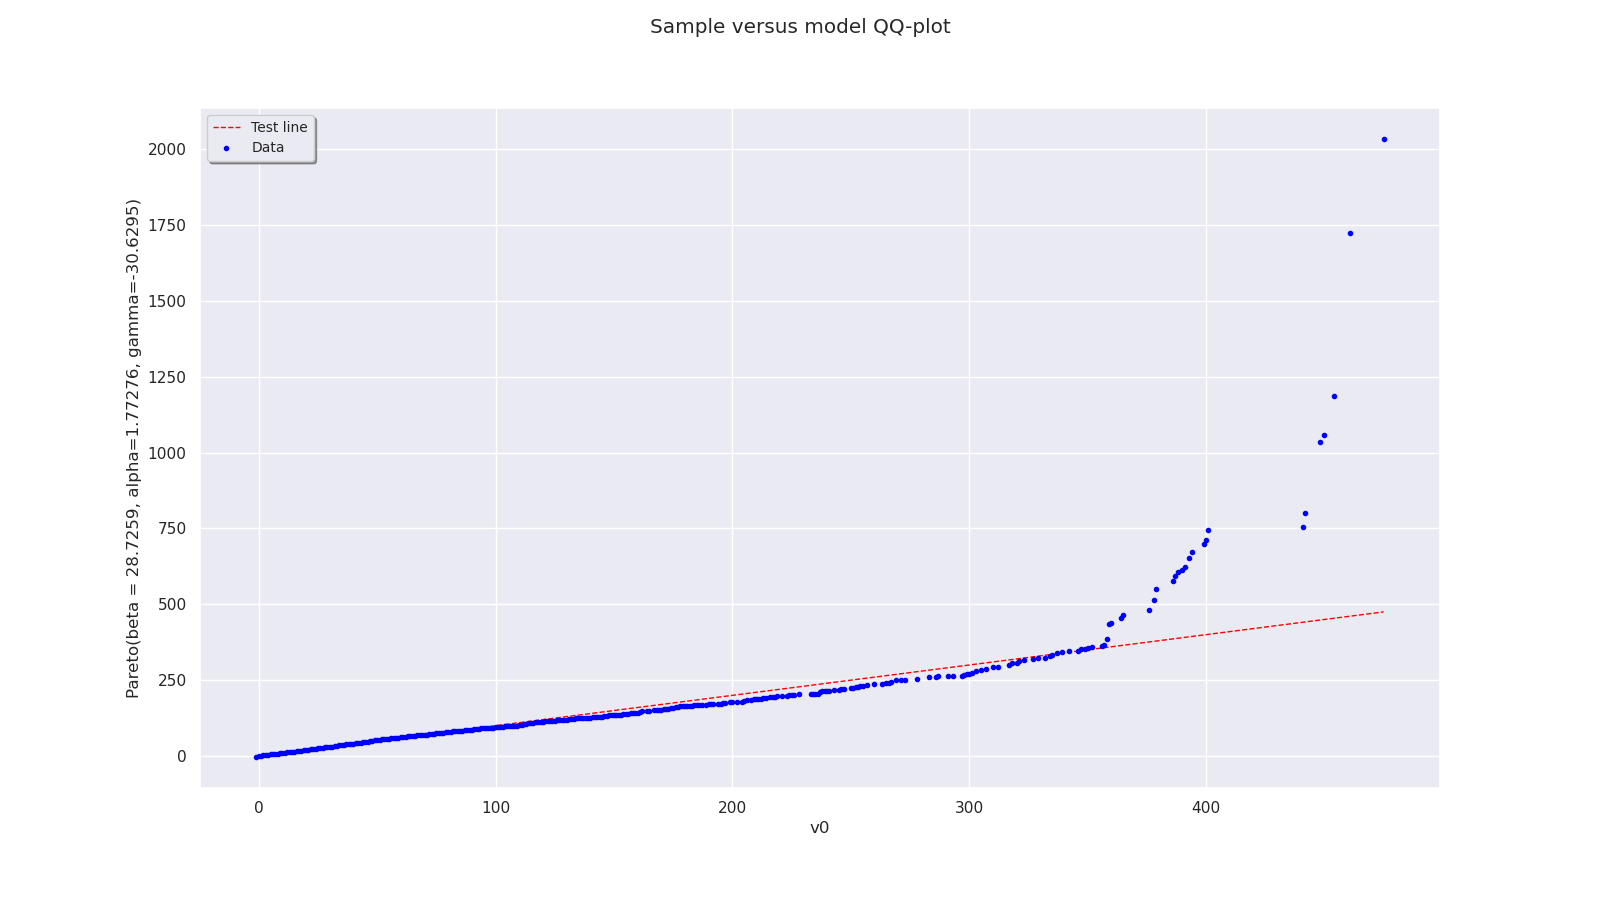

In [18]:
graph = ot.VisualTest.DrawQQplot(sample, distribution)
graph

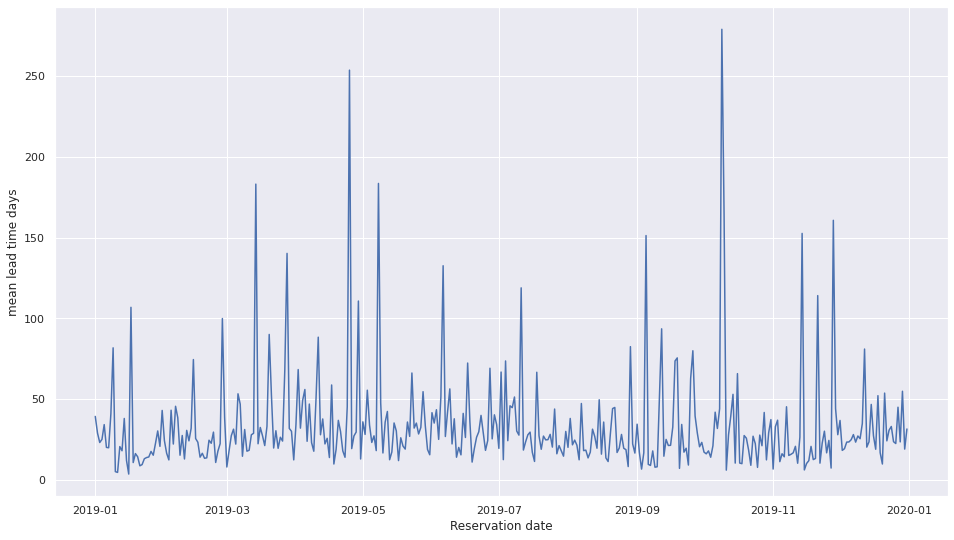

Text(0, 0.5, 'mean lead time days')

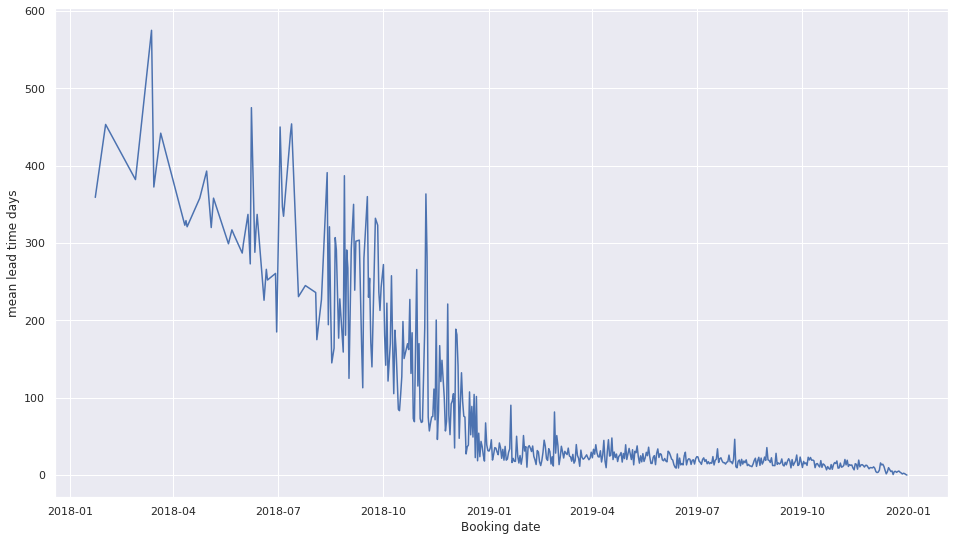

In [19]:
# aggregating mean lead time days by reservation date and booking date
lead_time_reservation_date = lead_time_df.reset_index().groupby(['Reservation date'], as_index=False).agg({'Booking lead time days': 'mean', 'Booking date': 'count'})
sns.lineplot(data=lead_time_reservation_date, x='Reservation date', y='Booking lead time days')
plt.ylabel("mean lead time days")
plt.show()
lead_time_booking_date = lead_time_df.reset_index().groupby(['Booking date'], as_index=False).agg({'Booking lead time days': 'mean'})
sns.lineplot(data=lead_time_booking_date, x='Booking date', y='Booking lead time days')
plt.ylabel("mean lead time days")

In [20]:
# obersing reserved dates with long lead time
lead_time_reservation_date['dow'] = lead_time_reservation_date['Reservation date'].dt.dayofweek
lead_time_reservation_date.loc[lead_time_reservation_date['Booking lead time days'] > 70].sort_values(by='Booking lead time days', ascending=False).head(10)

#lead_time_reservation_date.groupby(['dow']).mean()

Reservation date  Booking lead time days  Booking date  dow
281       2019-10-09              278.900000            20    2
114       2019-04-25              253.633333            30    3
127       2019-05-08              183.538462            39    2
72        2019-03-14              183.114286            35    3
282       2019-10-10              164.212766            47    3
331       2019-11-28              160.725000            40    3
317       2019-11-14              152.615385            39    3
247       2019-09-05              151.291667            24    3
86        2019-03-28              140.255319            47    3
156       2019-06-06              132.613636            44    3

### Observations about lead time

Lead time shows distribution following power law[2] and pareto distribution[3], the majority of reservations occur with short lead times.

We may estimate a pareto distribution which fits fairly close to our data. Using this distribution we can estimate probabilities of different outcomes. We may use two-sample to tests to detect any shift in distributions.

Looking at average lead time by booking date, we notice that average lead time decreases as the dates move on. This is expected as we only have reservations for a single year and people may make reservations during the previous year, but we only see them if they have a lead time long enough that they occur during 2019. Similarly for reservations which are made during 2019 but are for 2020, we do not see this data so we expect the negative relationship.

Looking at average lead time by reservation date we don't seasonality as previously seen in booking count. Spikes may not mean any specific event, but a higher percentage of customers choosing to book very early.

[2]: https://en.wikipedia.org/wiki/Power_law
[3]: https://en.wikipedia.org/wiki/Pareto_distribution

### Basic modelling

Checking a basic decision tree of date decomposition features can explain discretized lead time in days.

Training a model may give us insight on patterns with the lead time.

Model is heavily simplified; small decision tree, simplified features, simplified output. This model only acts to be an interpretable baseline.

In [21]:
# create encoding for each lead day
value_counts_per_lead = lead_time_df.reset_index().groupby('Reservation date')['Booking lead time days'].value_counts()
value_counts_per_lead = value_counts_per_lead.unstack(level=1).fillna(0)
value_counts_per_lead = value_counts_per_lead.reset_index()
X = value_counts_per_lead[['Reservation date']]
value_counts_per_lead = value_counts_per_lead.drop(columns=['Reservation date'])
y = value_counts_per_lead

In [22]:
# discretization of lead times
lead_time_quantiles = lead_time_df['Booking lead time days'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
print(f'lead time quantiles: {lead_time_quantiles}')
def sum_interquantile(x, q1, q2, equal_last=False):
    indexes = np.array(x.index)
    if equal_last:
        x[(indexes >= q1) & (indexes <= q2)].sum() / x.sum()
    return x[(indexes >= q1) & (indexes < q2)].sum() / x.sum()

q0_q1_sum = y.apply(lambda x: sum_interquantile(x, lead_time_quantiles[0], lead_time_quantiles[1]), axis=1)
q1_q2_sum = y.apply(lambda x: sum_interquantile(x, lead_time_quantiles[1], lead_time_quantiles[2]), axis=1)
q2_q3_sum = y.apply(lambda x: sum_interquantile(x, lead_time_quantiles[2], lead_time_quantiles[3]), axis=1)
q3_q4_sum = y.apply(lambda x: sum_interquantile(x, lead_time_quantiles[3], lead_time_quantiles[4], equal_last=True), axis=1)
y = pd.DataFrame({
    f'{lead_time_quantiles[0]} {lead_time_quantiles[1]} sum': q0_q1_sum,
    f'{lead_time_quantiles[1]} {lead_time_quantiles[2]} sum': q1_q2_sum,
    f'{lead_time_quantiles[2]} {lead_time_quantiles[3]} sum': q2_q3_sum,
    f'{lead_time_quantiles[3]} {lead_time_quantiles[4]} sum': q3_q4_sum,
})
display(y)

lead time quantiles: [-1.0, 3.0, 12.0, 32.0, 575.0]


-1.0 3.0 sum  3.0 12.0 sum  12.0 32.0 sum  32.0 575.0 sum
0        0.015625      0.125000       0.515625        0.343750
1        0.140000      0.040000       0.440000        0.380000
2        0.074074      0.222222       0.444444        0.259259
3        0.142857      0.238095       0.380952        0.238095
4        0.120000      0.400000       0.080000        0.400000
..            ...           ...            ...             ...
360      0.166667      0.083333       0.166667        0.583333
361      0.289474      0.236842       0.236842        0.236842
362      0.039216      0.215686       0.215686        0.529412
363      0.250000      0.214286       0.285714        0.250000
364      0.184713      0.210191       0.248408        0.356688

[365 rows x 4 columns]

In [23]:
# date decomposition as only feature
X['doy'] = X['Reservation date'].dt.dayofyear
X['dow'] = X['Reservation date'].dt.dayofweek
X['month'] = X['Reservation date'].dt.month
X['month'] = X['Reservation date'].dt.day
X = X.drop(columns=['Reservation date'])
display(X)

Booking lead time days  doy  dow  month
0                         1    1      1
1                         2    2      2
2                         3    3      3
3                         4    4      4
4                         5    5      5
..                      ...  ...    ...
360                     361    4     27
361                     362    5     28
362                     363    6     29
363                     364    0     30
364                     365    1     31

[365 rows x 3 columns]

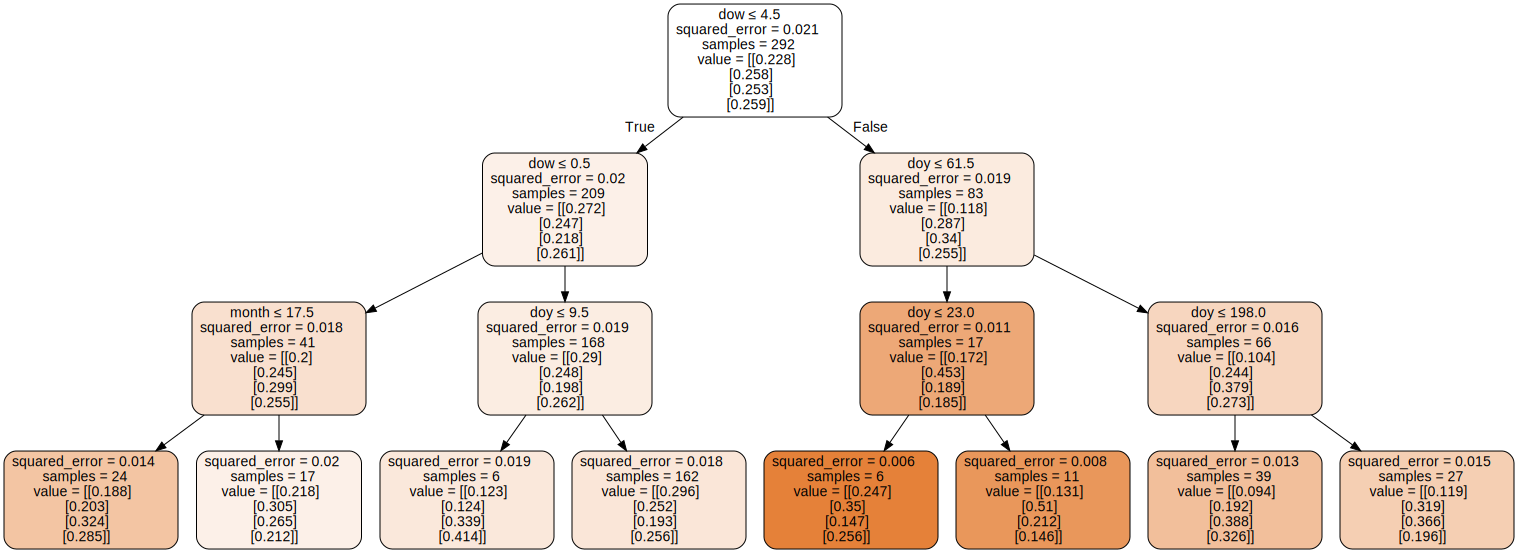

In [24]:
# modelling simple decision tree

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import graphviz

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

clf = DecisionTreeRegressor(max_depth=3)
clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X.columns,  
                     class_names=y.columns,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('dt.gv')
graph

In [25]:
# displaying feature importances
pd.DataFrame({'class': X.columns, 'importances': clf.feature_importances_})

class  importances
0    doy     0.442460
1    dow     0.522659
2  month     0.034881

In [26]:
# viewing ml evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def group_regression_eval(y_test, y_pred):
    metrics = {'target_class': [col for col in y.columns], 'mae': [], 'mse': [], 'rmse': [], 'r2': []}
    for idx in range(4):
        metrics['mae'].append(mean_absolute_error(y_test.iloc[:, idx], y_pred[:, idx]))
        metrics['mse'].append(mean_squared_error(y_test.iloc[:, idx], y_pred[:, idx]))
        metrics['rmse'].append(np.sqrt(metrics['mae'][-1]))
        metrics['r2'].append(r2_score(y_test.iloc[:, idx], y_pred[:, idx]))
    return pd.DataFrame(metrics)

print('eval on train, first 0.8 of year')
display(group_regression_eval(y_train, clf.predict(X_train)))
print('eval on test, last 0.2 of year')
display(group_regression_eval(y_test, clf.predict(X_test)))

eval on train, first 0.8 of year


target_class       mae       mse      rmse        r2
0    -1.0 3.0 sum  0.092945  0.015147  0.304869  0.309082
1    3.0 12.0 sum  0.096665  0.015010  0.310910  0.220855
2   12.0 32.0 sum  0.094440  0.014440  0.307312  0.310657
3  32.0 575.0 sum  0.108677  0.021238  0.329663  0.090909

eval on test, last 0.2 of year


target_class       mae       mse      rmse        r2
0    -1.0 3.0 sum  0.113183  0.018096  0.336427  0.319628
1    3.0 12.0 sum  0.133610  0.025930  0.365527 -0.131487
2   12.0 32.0 sum  0.107225  0.017284  0.327452  0.303224
3  32.0 575.0 sum  0.127924  0.024772  0.357665 -0.118793

1. Model is not able to generalize to later part of year.
2. Highest feature importances for dow and doy.
3. We may traverse tree to low error leaves to see some patterns which are explainable.

# Q3 0.5/8 * 25 = 1.5625 minutes

Prediction of lead time can give the hotel an understanding of its availability. They may understand on the distribution how many bookings would come with what lead time. This may be an indicator for demand, e.g. the demand is low when booking with larger lead times so we may reduce price if it is calculated that the proportion of bookings would leave us with empty rooms.

# Q4 1.5/8 * 25 = 4.6875 minutes

Analysing potential features from the data and relating to Q1. Recall Q1 answered about patterns from Hotel A's final bookings per night.

In [27]:
# Summary statistics of the date
prices_df = pd.read_csv('data/competitor_prices.csv', index_col=0)
prices_df['Reservation date'] = pd.to_datetime(prices_df['Reservation date'])
display(prices_df)
display(prices_df.dtypes)
display(prices_df.isnull().sum())
prices_df = prices_df.fillna('n/a')
display(prices_df['Room type'].unique())
display(prices_df['Hotel name'].unique())
display(prices_df['Price'].describe())
display(prices_df.groupby('Hotel name')['Price'].describe().drop(columns='count'))
display(prices_df.groupby(['Hotel name', 'Room type'])['Price'].describe().drop(columns='count'))

Price Reservation date    Room type Hotel name
0      27.9       2023-10-18          NaN    Hotel C
1      25.7       2023-10-18    Twin room    Hotel C
2     184.0       2023-10-18       Studio    Hotel D
3      44.9       2023-10-18  Single room        NaN
4      35.0       2023-10-18  Female dorm   Hostel A
...     ...              ...          ...        ...
4295  320.0       2022-10-20  Family room    Hotel B
4296   41.1       2022-10-20    Twin room        NaN
4297  155.0       2022-10-20       Studio    Hotel D
4298   53.0       2022-10-20    Male dorm   Hostel A
4299   18.4       2022-10-20          NaN    Hotel C

[4300 rows x 4 columns]

Price                      float64
Reservation date    datetime64[ns]
Room type                   object
Hotel name                  object
dtype: object

Price                  0
Reservation date       0
Room type            728
Hotel name          1092
dtype: int64

array(['n/a', 'Twin room', 'Studio', 'Single room', 'Female dorm',
       'Male dorm', 'Large dorm', 'Luxury suite', 'Family room'],
      dtype=object)

array(['Hotel C', 'Hotel D', 'n/a', 'Hostel A', 'Hostel B', 'Hotel B'],
      dtype=object)

count    4300.000000
mean       92.430647
std       109.410064
min        15.700000
25%        29.600000
50%        38.535000
75%        93.000000
max      1250.000000
Name: Price, dtype: float64

mean        std    min    25%    50%      75%     max
Hotel name                                                             
Hostel A     54.806154  83.118079   23.0   34.0   42.5   55.000  1250.0
Hostel B     32.467308   6.654132   21.0   27.0   34.0   38.525    48.0
Hotel B     310.033333  36.246778  217.0  283.0  316.0  334.250   496.0
Hotel C      26.429212   6.793861   15.7   21.8   25.9   30.000    77.5
Hotel D     186.623626  49.137112  118.0  156.0  184.0  196.000   300.0
n/a          40.587088  10.387173   25.2   34.3   38.7   44.300   119.4

mean        std     min      25%     50%  \
Hotel name Room type                                                      
Hostel A   Female dorm    58.589698  91.854747   23.75   37.500   43.75   
           Male dorm      51.022610  73.282045   23.00   34.000   39.00   
Hostel B   Large dorm     32.467308   6.654132   21.00   27.000   34.00   
Hotel B    Family room   300.033333  34.864333  217.00  269.000  302.00   
           Luxury suite  320.033333  34.864333  237.00  289.000  322.00   
Hotel C    Single room    29.861538   7.079295   19.80   24.675   30.00   
           Twin room      23.684615   5.615208   15.70   19.575   23.80   
           n/a            25.741484   6.102116   17.10   21.275   25.90   
Hotel D    Studio        186.623626  49.137112  118.00  156.000  184.00   
n/a        Single room    45.862637  10.812618   31.80   40.000   44.80   
           Twin room      36.363462   8.576681   25.20   31.700   35.50   
           n/a            39.535165   9.321832   27.40   34.500   38.60   

                             75%     max  
Hotel name Room type                      
Hostel A   Female dorm    61.250  1250.0  
           Male dorm      53.000  1000.0  
Hostel B   Large dorm     38.525    48.0  
Hotel B    Family room   321.000   476.0  
           Luxury suite  341.000   496.0  
Hotel C    Single room    33.900    77.5  
           Twin room      26.900    61.5  
           n/a            29.200    66.8  
Hotel D    Studio        196.000   300.0  
n/a        Single room    48.700   119.4  
           Twin room      38.600    94.7  
           n/a            42.000   102.9

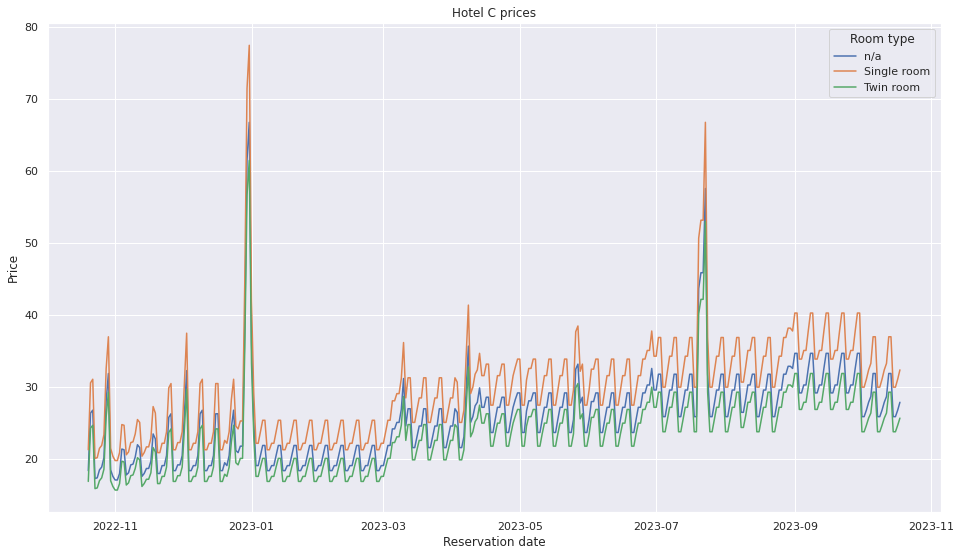

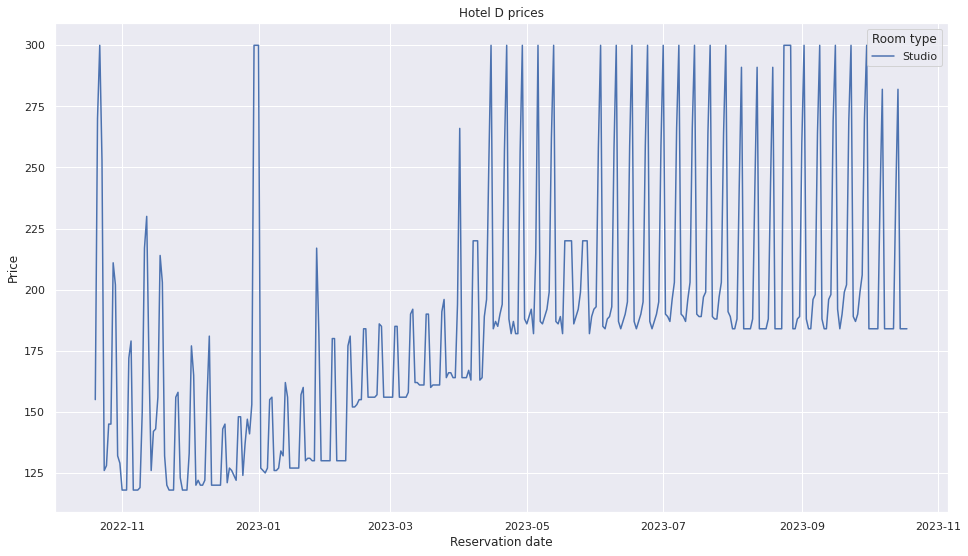

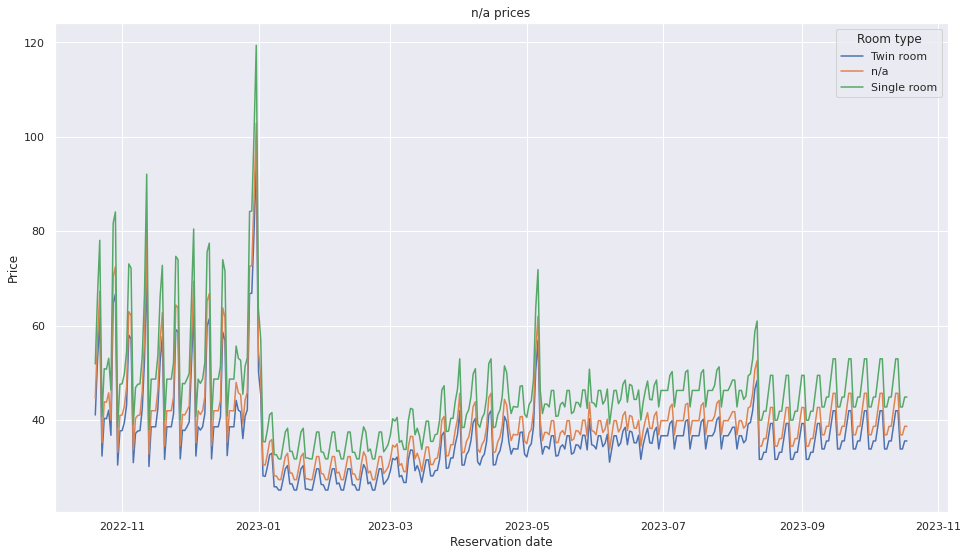

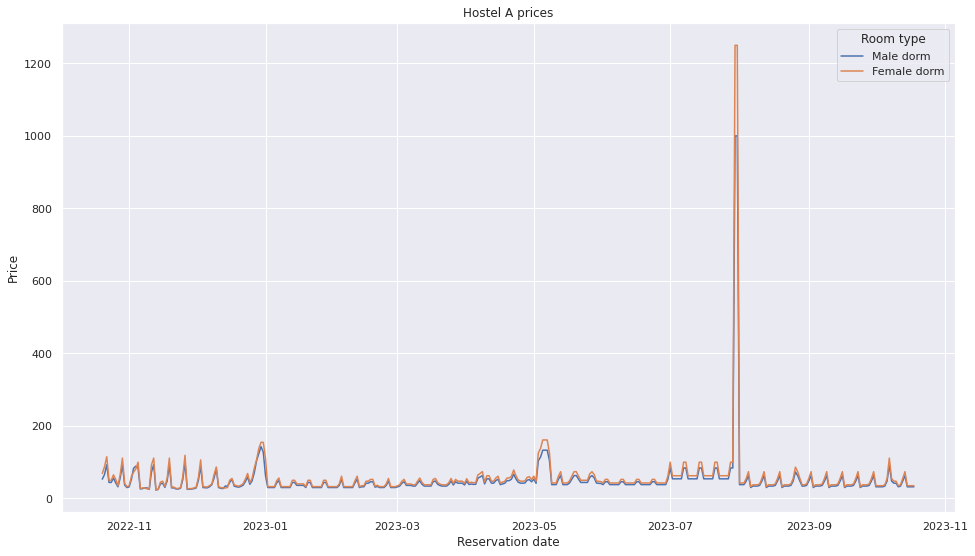

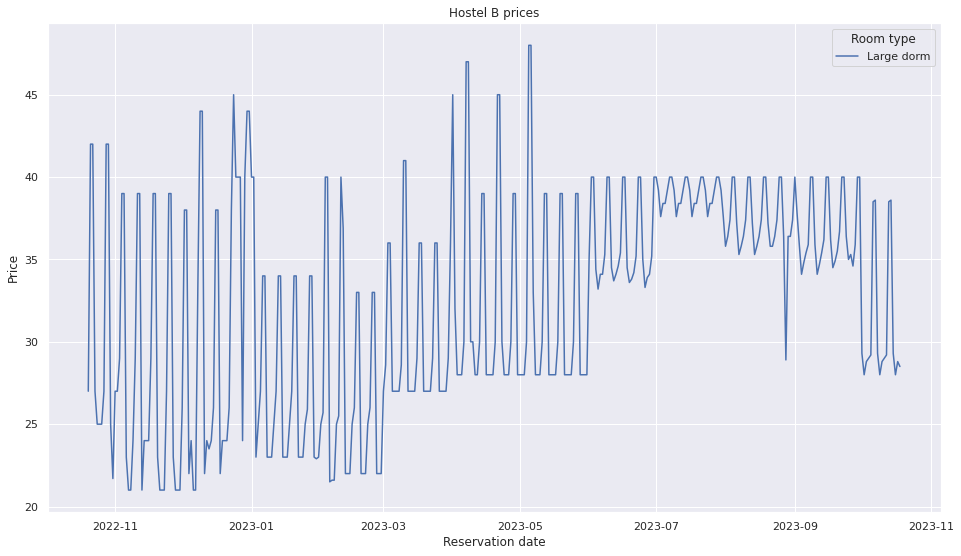

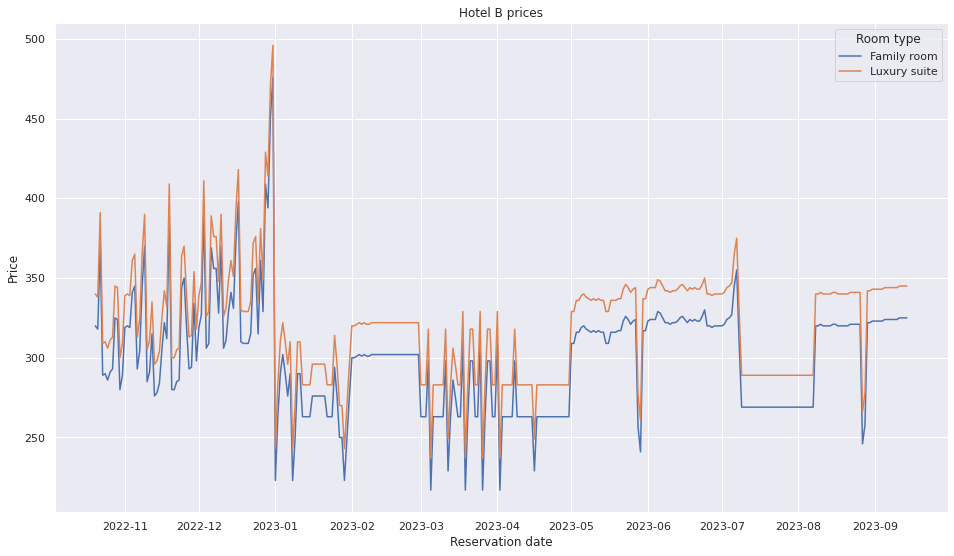

Text(0.5, 1.0, 'All hotel mean prices per day')

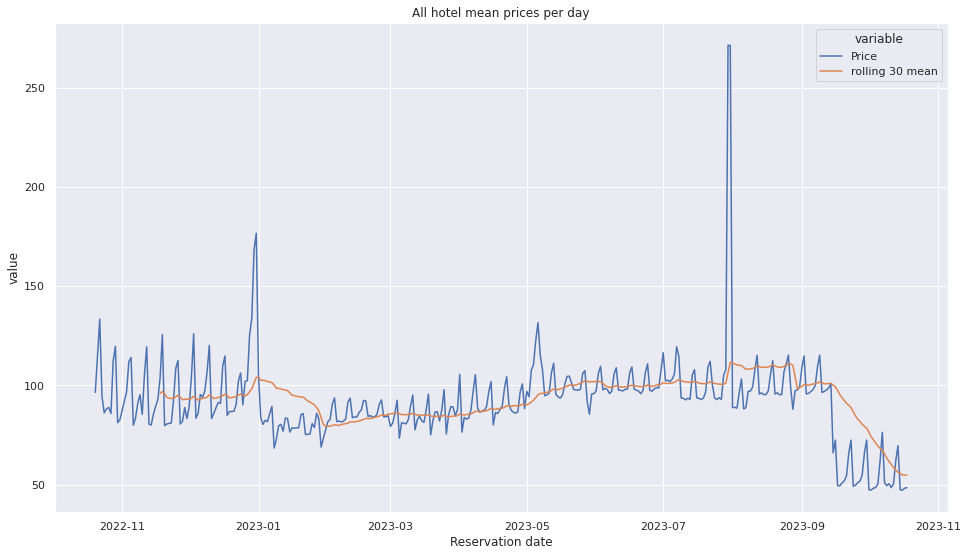

In [28]:
# plotting time series of prices for the hotels
for hotel in prices_df['Hotel name'].unique():
    hotel_plot_prices = prices_df.loc[prices_df['Hotel name'] == hotel].sort_values(by='Reservation date')
    sns.lineplot(data=hotel_plot_prices, x='Reservation date', y='Price', hue='Room type')
    plt.title(f'{hotel} prices')
    plt.show()

hotel_plot_prices = prices_df.groupby('Reservation date', as_index=False).agg({'Price': 'mean'})
hotel_plot_prices['rolling 30 mean'] = hotel_plot_prices.rolling(30)['Price'].mean()
hotel_plot_prices = hotel_plot_prices.melt(id_vars='Reservation date')
sns.lineplot(data=hotel_plot_prices, x='Reservation date', y='value', hue='variable')
plt.title(f'All hotel mean prices per day')

<AxesSubplot:>

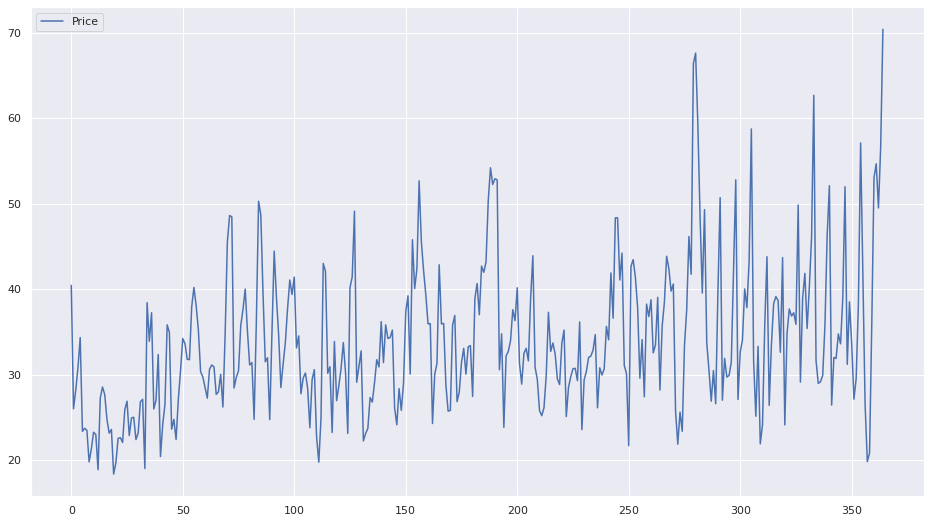

In [29]:
# observing hotel A price by reserved date, checking for seasonality and trends
sns.lineplot(data=bookings_df.groupby('Reservation date', as_index=False).agg({'Price': 'mean'}))

### Features from competitor pricing

The main column we are focusing on is Price. We look at price from different segments and angles.

We can look at competitor pricing summary statistics and see what type of offering or quality a hotel is to be, with mean price being the main signal. An aggregate of enough hotels will give us an idea of the average price a customer is willing to pay for a hotel and we may adjust our price according to our offering.

Plotting the prices over time as a timeseries we can see some hotels have clearly seasonality in their pricing.  We can also observe some changes in the variance of the seasonality over time which may be a signal of certainty of price and demand during different periods. There are some peaks which may be due to certain events at the hotel or fully booked rooms.

### How does this relate to the bookings counts and demand, and related strategies for pricing?

We mentioned before that the final bookings relate to demand. Demand is the want for the hotel booking while the final booking count is the need for the hotel booking. Using the bookings as a signal for demand we can adjust pricing as the demand moves with an inverse relationship.

Competitor pricing can act as an additive layer towards the previous strategy. Pricing based on competitors may be viewed as a low risk strategy, but is not reflective of the demand of our own hotel. 

Competitor pricing strategy tracks with the market of hotels but is not reactive to our own customers and other factors which affect our demand.

# Q5 2.5/8 * 25 = 7.8125 mins

Similarity to Hotel A and Why. The method to check similarity is based on checking timeseries for both the counts and price.

In [30]:
# read and formatting
competitor_bookings = pd.read_csv('data/competitor_bookings.csv', index_col=0)
competitor_bookings['Reservation date'] = pd.to_datetime(competitor_bookings['Reservation date'])
competitor_bookings['Booking date'] = pd.to_datetime(competitor_bookings['Booking date'])
display(competitor_bookings)
display(competitor_bookings.isnull().sum())
display(competitor_bookings.dtypes)

Booking date                            Booking ID Reservation date  \
0        2020-01-01  8e9ab5ca-be2e-471e-b386-ab35002abdd2       2019-12-31   
1        2019-12-31  7385d178-fffb-4c34-b8d2-ab340111fe50       2019-12-31   
2        2019-12-31  045f6460-4df1-40cc-ac0b-ab34000bde26       2019-12-30   
3        2019-12-31  765e0bb8-af99-4b9d-ae93-ab3400f7189a       2019-12-31   
4        2019-12-31  521122e6-144b-4d56-8dc2-ab3400fa7131       2019-12-31   
...             ...                                   ...              ...   
169279          NaT                                   NaN       2019-09-10   
169280          NaT                                   NaN       2019-11-15   
169281          NaT                                   NaN       2019-09-02   
169282          NaT                                   NaN       2019-08-21   
169283          NaT                                   NaN       2019-09-08   

       Rate plan type Hotel name     Room type  Number of rooms booked  Price  
0             Dynamic   Hostel A   Female dorm                       1  74.20  
1             Dynamic   Hostel A     Male dorm                       1  61.60  
2             Dynamic   Hostel A     Male dorm                       1  26.50  
3             Dynamic   Hostel B    Large dorm                       1  50.22  
4             Dynamic   Hostel A     Male dorm                       1  63.60  
...               ...        ...           ...                     ...    ...  
169279  Miscellaneous    Hotel B   Family room                       0   0.00  
169280  Miscellaneous    Hotel B   Family room                       0   0.00  
169281  Miscellaneous   Hostel A   Female dorm                       0   0.00  
169282  Miscellaneous    Hotel B  Luxury suite                       0   0.00  
169283  Miscellaneous    Hotel B   Family room                       0   0.00  

[169284 rows x 8 columns]

Booking date              236
Booking ID                236
Reservation date            0
Rate plan type              0
Hotel name                  0
Room type                   0
Number of rooms booked      0
Price                       0
dtype: int64

Booking date              datetime64[ns]
Booking ID                        object
Reservation date          datetime64[ns]
Rate plan type                    object
Hotel name                        object
Room type                         object
Number of rooms booked             int64
Price                            float64
dtype: object

In [31]:
# check missing data, seems to be error with system as price and number of rooms booked are 0
# could also mean that these hotels were not open during those dates
competitor_bookings.loc[competitor_bookings['Booking date'].isnull()].sort_values(['Hotel name', 'Reservation date'])

Booking date Booking ID Reservation date Rate plan type Hotel name  \
169281          NaT        NaN       2019-09-02  Miscellaneous   Hostel A   
169135          NaT        NaN       2019-12-23  Miscellaneous   Hostel B   
169199          NaT        NaN       2019-12-23  Miscellaneous   Hostel B   
169072          NaT        NaN       2019-12-24  Miscellaneous   Hostel B   
169083          NaT        NaN       2019-12-24  Miscellaneous   Hostel B   
...             ...        ...              ...            ...        ...   
169248          NaT        NaN       2019-11-28  Miscellaneous    Hotel B   
169202          NaT        NaN       2019-11-29  Miscellaneous    Hotel B   
169265          NaT        NaN       2019-11-29  Miscellaneous    Hotel B   
169070          NaT        NaN       2019-11-30  Miscellaneous    Hotel B   
169276          NaT        NaN       2019-11-30  Miscellaneous    Hotel B   

           Room type  Number of rooms booked  Price  
169281   Female dorm                       0    0.0  
169135    Large dorm                       0    0.0  
169199    Small dorm                       0    0.0  
169072    Small dorm                       0    0.0  
169083    Large dorm                       0    0.0  
...              ...                     ...    ...  
169248  Luxury suite                       0    0.0  
169202  Luxury suite                       0    0.0  
169265   Family room                       0    0.0  
169070   Family room                       0    0.0  
169276  Luxury suite                       0    0.0  

[236 rows x 8 columns]

In [32]:
# aggregate bookings per day
competitor_bookings_per_day = competitor_bookings.groupby(['Reservation date', 'Hotel name'], as_index=False)['Booking date'].count()
competitor_bookings_per_day = pd.DataFrame(competitor_bookings_per_day).rename(columns={'Booking date': 'Booking count'})

# aggregate price per day
competitor_price_per_day = competitor_bookings.groupby(['Reservation date', 'Hotel name'], as_index=False)['Price'].mean()

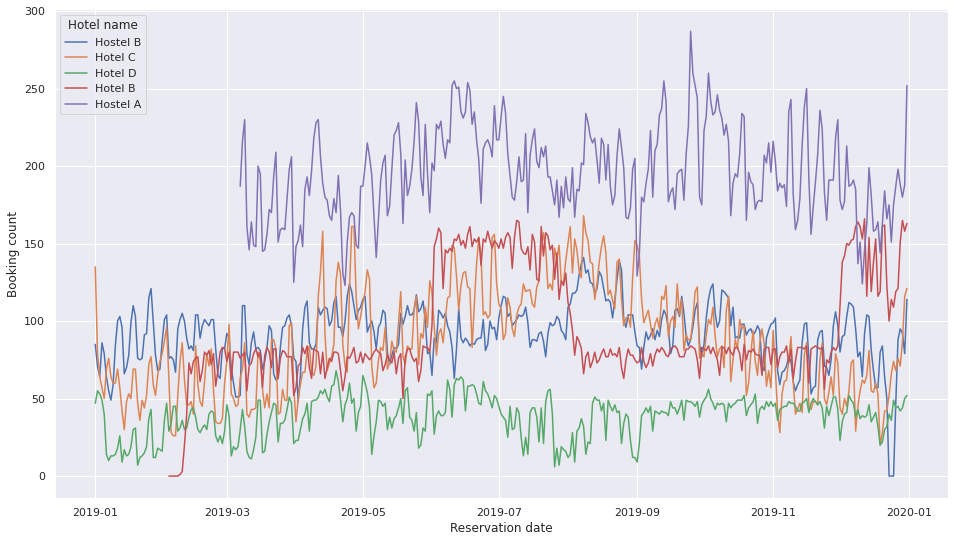

<AxesSubplot:xlabel='Reservation date', ylabel='Price'>

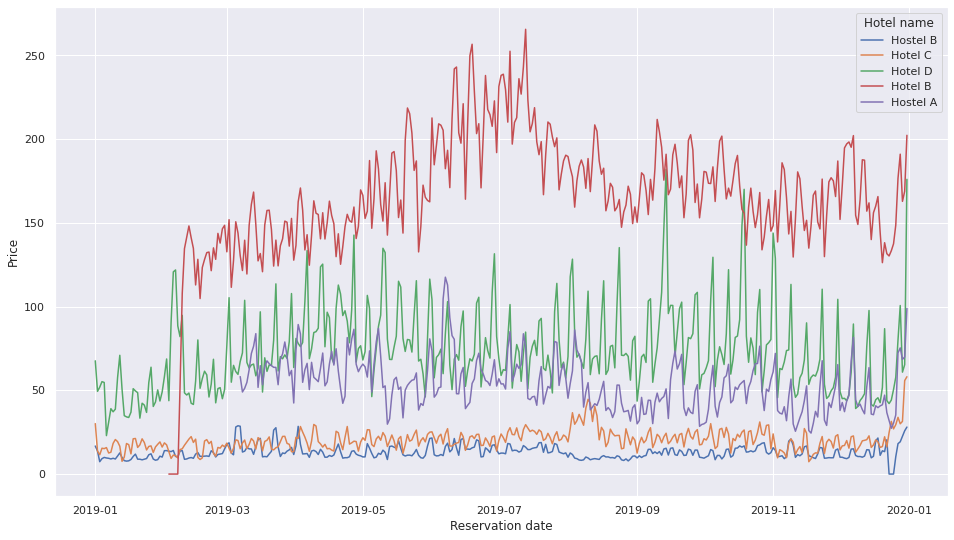

In [33]:
sns.lineplot(data=competitor_bookings_per_day, x='Reservation date', y='Booking count', hue='Hotel name')
plt.show()
sns.lineplot(data=competitor_price_per_day, x='Reservation date', y='Price', hue='Hotel name')
#sns.lineplot(data=plot_df, x='Reservation date', y='value', hue='variable')

In [34]:
def preprocess_timeseries(ts, normalize=True, rolling=True, lag=True):
    if normalize:
        ts = ts.apply(lambda x: x - x.mean(), axis=0) # mean offset
        ts = ts.apply(lambda x: (x - x.mean())/x.std(), axis=0) # scaling
    for col in ts.columns:
        if rolling:
            ts[f'7 day rolling mean {col}'] = ts.rolling(7)[col].mean()
            ts[f'30 day rolling mean {col}'] = ts.rolling(30)[col].mean()
        if lag:
            ts[f'lag 3 {col}'] = ts[col].shift(3)
            ts[f'lag 7 {col}'] = ts[col].shift(7)
    ts = ts.reset_index()
    return ts

# further formatting as features
competitor_bookings_per_day = competitor_bookings_per_day.pivot(index='Reservation date', columns='Hotel name')
competitor_bookings_per_day.columns = [f'{a} {b}' for a, b in competitor_bookings_per_day.columns]
competitor_bookings_per_day.reset_index()

# normalizing/scaling time series
competitor_bookings_per_day_orig = competitor_bookings_per_day.copy()
competitor_bookings_per_day = preprocess_timeseries(competitor_bookings_per_day)

bookings_per_day_orig = bookings_per_day.copy()
bookings_per_day['Booking count'] = bookings_per_day['Booking count'] - bookings_per_day['Booking count'].mean()
bookings_per_day['Booking count'] = (bookings_per_day['Booking count'] - bookings_per_day['Booking count'].mean())/bookings_per_day['Booking count'].std()
bookings_per_day['7 day rolling mean Booking count'] = bookings_per_day.rolling(7)['Booking count'].mean()
bookings_per_day['30 day rolling mean Booking count'] = bookings_per_day.rolling(30)['Booking count'].mean()
bookings_per_day['lag 3 Booking count'] = bookings_per_day['Booking count'].shift(0) # for comparing lagged feature with actual non-lagged original
bookings_per_day['lag 7 Booking count'] = bookings_per_day['Booking count'].shift(0)

In [35]:
# same for price
competitor_price_per_day = competitor_price_per_day.pivot(index='Reservation date', columns='Hotel name')
competitor_price_per_day.columns = [f'{a} {b}' for a, b in competitor_price_per_day.columns]
competitor_price_per_day.reset_index()

competitor_price_per_day_orig = competitor_price_per_day.copy()
competitor_price_per_day = preprocess_timeseries(competitor_price_per_day)

price_per_day = bookings_df.groupby('Reservation date', as_index=False)['Price'].mean()
price_per_day_orig = price_per_day.copy()
price_per_day['Price'] = price_per_day['Price'] - price_per_day['Price'].mean()
price_per_day['Price'] = (price_per_day['Price'] - price_per_day['Price'].mean())/price_per_day['Price'].std()
price_per_day['7 day rolling mean Price'] = price_per_day.rolling(7)['Price'].mean()
price_per_day['30 day rolling mean Price'] = price_per_day.rolling(30)['Price'].mean()
price_per_day['lag 3 Price'] = price_per_day['Price'].shift(0)
price_per_day['lag 7 Price'] = price_per_day['Price'].shift(0)

In [36]:
# using rmse to measure similarity, also know of dynamic time warping
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    """ rmse while skipping na
    """
    mask = (~y_true.isnull() & ~y_pred.isnull())
    return np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))

hotel_names = ['Hostel A', 'Hostel B', 'Hotel B', 'Hotel C', 'Hotel D']
feature_names = ['Booking count', '7 day rolling mean Booking count', '30 day rolling mean Booking count', 'lag 3 Booking count', 'lag 7 Booking count']

hotels = []
feature_col = []
rmse_out = []
feature_type =[]
for feature_name in feature_names:
    for hotel in hotel_names:
        hotels.append(hotel)
        feature_type.append('count')
        feature_col.append(feature_name)
        rmse_out.append(rmse(bookings_per_day[feature_name], competitor_bookings_per_day[f'{feature_name} {hotel}']))

price_feature_names = ['Price', '7 day rolling mean Price', '30 day rolling mean Price', 'lag 3 Price', 'lag 7 Price']

for feature_name in price_feature_names:
    for hotel in hotel_names:
        hotels.append(hotel)
        feature_type.append('price')
        feature_col.append(feature_name)
        rmse_out.append(rmse(price_per_day[feature_name], competitor_price_per_day[f'{feature_name} {hotel}']))

In [37]:
rmse_df = pd.DataFrame({'feature': feature_col, 'feature_type': feature_type, 'hotel': hotels, 'rmse': rmse_out})
display(rmse_df)
display(rmse_df.groupby('hotel')['rmse'].mean())
display(rmse_df.groupby(['hotel', 'feature_type'])['rmse'].mean())
best_hotels = ['Hotel C', 'Hostel B', 'Hostel A']

feature feature_type     hotel      rmse
0                       Booking count        count  Hostel A  0.953254
1                       Booking count        count  Hostel B  0.979441
2                       Booking count        count   Hotel B  1.282079
3                       Booking count        count   Hotel C  0.847889
4                       Booking count        count   Hotel D  1.159223
5    7 day rolling mean Booking count        count  Hostel A  0.672352
6    7 day rolling mean Booking count        count  Hostel B  0.681478
7    7 day rolling mean Booking count        count   Hotel B  1.023609
8    7 day rolling mean Booking count        count   Hotel C  0.611620
9    7 day rolling mean Booking count        count   Hotel D  0.846840
10  30 day rolling mean Booking count        count  Hostel A  0.477196
11  30 day rolling mean Booking count        count  Hostel B  0.424934
12  30 day rolling mean Booking count        count   Hotel B  0.730838
13  30 day rolling mean Booking count        count   Hotel C  0.454970
14  30 day rolling mean Booking count        count   Hotel D  0.665588
15                lag 3 Booking count        count  Hostel A  1.264365
16                lag 3 Booking count        count  Hostel B  1.347322
17                lag 3 Booking count        count   Hotel B  1.244994
18                lag 3 Booking count        count   Hotel C  1.210036
19                lag 3 Booking count        count   Hotel D  1.337423
20                lag 7 Booking count        count  Hostel A  1.059482
21                lag 7 Booking count        count  Hostel B  1.125143
22                lag 7 Booking count        count   Hotel B  1.229058
23                lag 7 Booking count        count   Hotel C  0.911809
24                lag 7 Booking count        count   Hotel D  1.260932
25                              Price        price  Hostel A  1.129710
26                              Price        price  Hostel B  1.193255
27                              Price        price   Hotel B  1.213947
28                              Price        price   Hotel C  1.141007
29                              Price        price   Hotel D  1.166206
30           7 day rolling mean Price        price  Hostel A  0.864031
31           7 day rolling mean Price        price  Hostel B  0.740150
32           7 day rolling mean Price        price   Hotel B  0.815250
33           7 day rolling mean Price        price   Hotel C  0.782122
34           7 day rolling mean Price        price   Hotel D  0.772991
35          30 day rolling mean Price        price  Hostel A  0.686005
36          30 day rolling mean Price        price  Hostel B  0.434040
37          30 day rolling mean Price        price   Hotel B  0.621526
38          30 day rolling mean Price        price   Hotel C  0.544364
39          30 day rolling mean Price        price   Hotel D  0.497583
40                        lag 3 Price        price  Hostel A  1.490712
41                        lag 3 Price        price  Hostel B  1.323408
42                        lag 3 Price        price   Hotel B  1.284970
43                        lag 3 Price        price   Hotel C  1.220720
44                        lag 3 Price        price   Hotel D  1.350827
45                        lag 7 Price        price  Hostel A  1.371091
46                        lag 7 Price        price  Hostel B  1.288572
47                        lag 7 Price        price   Hotel B  1.317966
48                        lag 7 Price        price   Hotel C  1.219877
49                        lag 7 Price        price   Hotel D  1.239368

hotel
Hostel A    0.996820
Hostel B    0.953774
Hotel B     1.076424
Hotel C     0.894441
Hotel D     1.029698
Name: rmse, dtype: float64

hotel     feature_type
Hostel A  count           0.885330
          price           1.108310
Hostel B  count           0.911664
          price           0.995885
Hotel B   count           1.102116
          price           1.050732
Hotel C   count           0.807265
          price           0.981618
Hotel D   count           1.054001
          price           1.005395
Name: rmse, dtype: float64

<AxesSubplot:xlabel='Reservation date', ylabel='Price'>

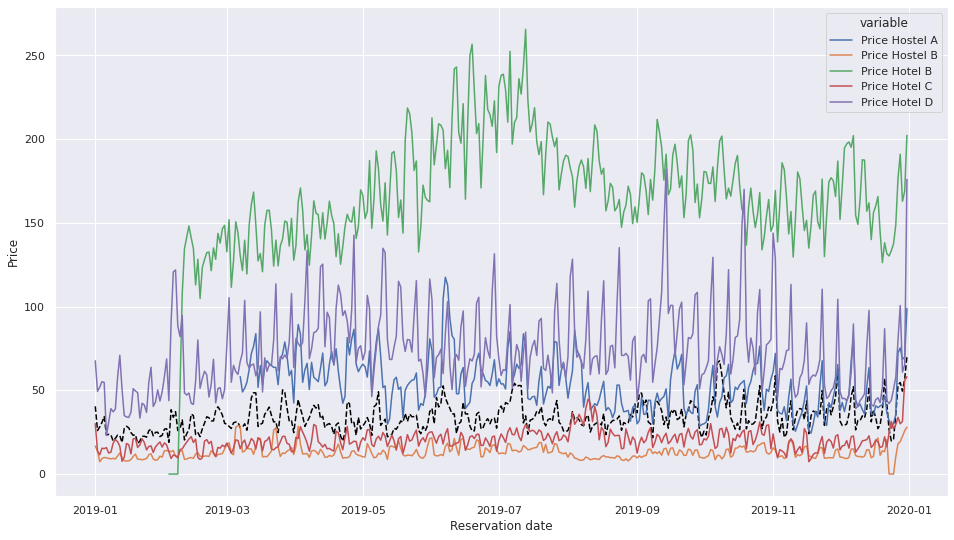

In [38]:
sns.lineplot(data=price_per_day_orig, x='Reservation date', y='Price', color='black', linestyle='--')
sns.lineplot(data=pd.melt(competitor_price_per_day_orig.reset_index(), id_vars='Reservation date'), x='Reservation date', y='value', hue='variable')

<AxesSubplot:xlabel='Reservation date', ylabel='Price'>

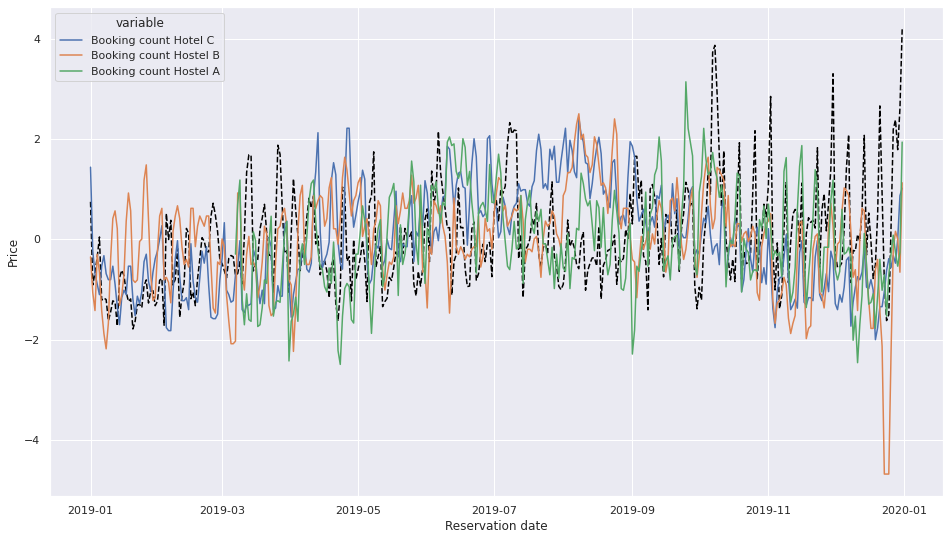

In [39]:
cols = ['Booking count'] #, '7 day rolling mean Booking count', '30 day rolling mean Booking count']
plot_df = competitor_bookings_per_day[['Reservation date'] + [f'{col} {hotel}' for col, hotel in product(cols, best_hotels)]]
sns.lineplot(data=price_per_day, x='Reservation date', y='Price', color='black', linestyle='--')
sns.lineplot(data=pd.melt(plot_df, id_vars='Reservation date'), x='Reservation date', y='value', hue='variable')

<AxesSubplot:xlabel='Reservation date', ylabel='Booking count'>

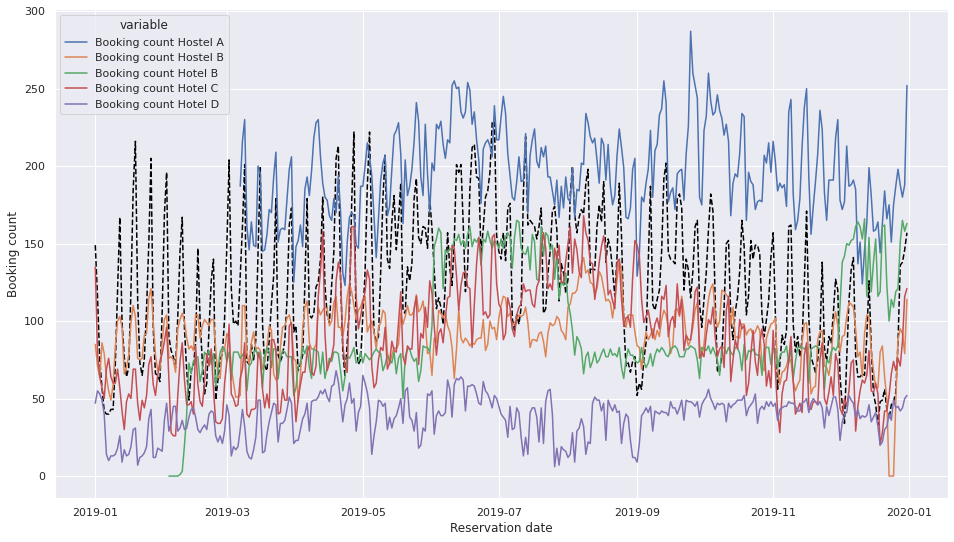

In [40]:
sns.lineplot(data=bookings_per_day_orig, x='Reservation date', y='Booking count', color='black', linestyle='--')
sns.lineplot(data=pd.melt(competitor_bookings_per_day_orig.reset_index(), id_vars='Reservation date'), x='Reservation date', y='value', hue='variable')

<AxesSubplot:xlabel='Reservation date', ylabel='Price'>

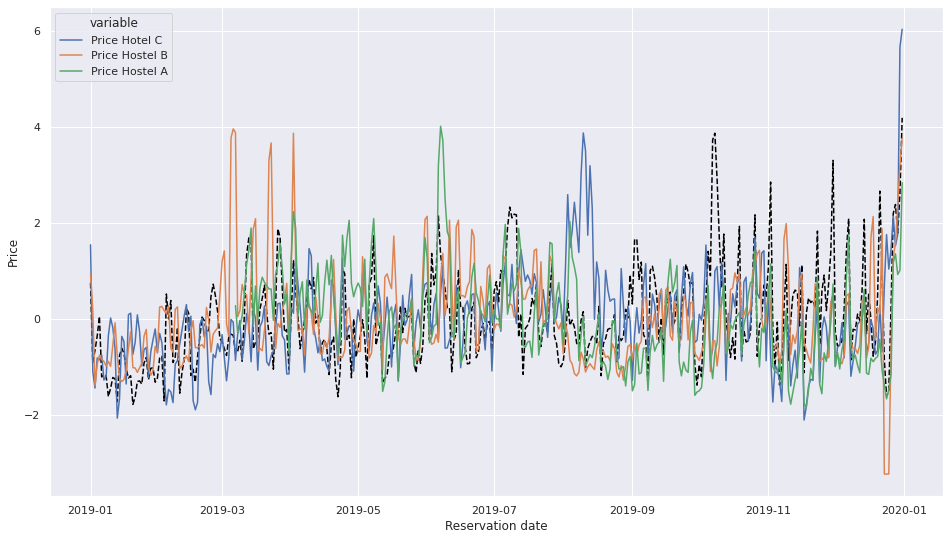

In [41]:
cols = ['Price'] #, '7 day rolling mean Price', '30 day rolling mean Price']
plot_df = competitor_price_per_day[['Reservation date'] + [f'{col} {hotel}' for col, hotel in product(cols, best_hotels)]]
sns.lineplot(data=price_per_day, x='Reservation date', y='Price', color='black', linestyle='--')
sns.lineplot(data=pd.melt(plot_df, id_vars='Reservation date'), x='Reservation date', y='value', hue='variable')

When making visualizations of the time series the similarity is not obvious and a more involved approach is used.

Using price and count time series we find similarity by first pre-processing removing offset, then standardizing and then using rmse as a measure of similarity. We also check the 7 day and 30 day rolling averages as to combat noise. If more time available may also remove the linear trend.

There are other alternatives such as using neural network architectures to create embedded vectors which may also find similarity. We may then use the embedded vector as a representitive of the timeseries and find similarity again with euclidean distance.

In [42]:
# modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

X_price = competitor_price_per_day_orig.copy()
X_price = preprocess_timeseries(X_price, normalize=True)
X_price = X_price.fillna(0)

X_bookings = competitor_bookings_per_day_orig.copy()
X_bookings = preprocess_timeseries(X_bookings, normalize=True)
X_bookings = X_bookings.fillna(0)

In [43]:
X = pd.concat([X_price, X_bookings.drop(columns='Reservation date')], axis=1)
X['dow'] = X['Reservation date'].dt.dayofweek
X['doy'] = X['Reservation date'].dt.dayofyear
X['month'] = X['Reservation date'].dt.month
X = X.drop(columns='Reservation date')

In [44]:
# predicting, ensuring no data leakage during transforms
y_bookings = bookings_per_day_orig['Booking count']

X_train, X_test, y_train, y_bookings_test = train_test_split(X, y_bookings, test_size=0.2, shuffle=False)
y_bookings_mean = y_train.mean()
y_train = y_train - y_bookings_mean
y_bookings_mean_2 = y_train.mean()
y_bookings_std = y_train.std()
y_train = (y_train - y_bookings_mean_2)/y_bookings_std
y_bookings_train = y_train
model_bookings = GradientBoostingRegressor()
model_bookings.fit(X_train, y_bookings_train)
y_bookings_pred = model_bookings.predict(X_test)
y_bookings_pred = y_bookings_pred*y_bookings_std + y_bookings_mean_2 + y_bookings_mean

y_price = price_per_day_orig['Price']

X_train, X_test, y_train, y_price_test = train_test_split(X, y_price, test_size=0.2, shuffle=False)
y_price_mean = y_train.mean()
y_train = y_train - y_price_mean
y_price_mean_2 = y_train.mean()
y_price_std = y_train.std()
y_train = (y_train - y_price_mean_2)/y_price_std
y_price_train = y_train
model_price = GradientBoostingRegressor()
model_price.fit(X_train, y_price_train)
y_price_pred = model_price.predict(X_test)
y_price_pred = y_price_pred*y_price_std + y_price_mean_2 + y_price_mean

In [45]:
def regression_eval(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

print('Bookings prediction')
display(regression_eval(y_bookings_test, y_bookings_pred))
print('Price prediction')
display(regression_eval(y_price_test, y_price_pred))

Bookings prediction


{'mae': 21.34863893424557,
 'mse': 736.8310270019917,
 'rmse': 27.14463164240752,
 'r2': 0.4505791245341778}

Price prediction


{'mae': 7.313860614174401,
 'mse': 85.52637954302651,
 'rmse': 9.248047336763936,
 'r2': 0.18296571368175396}

Text(0.5, 1.0, 'Price')

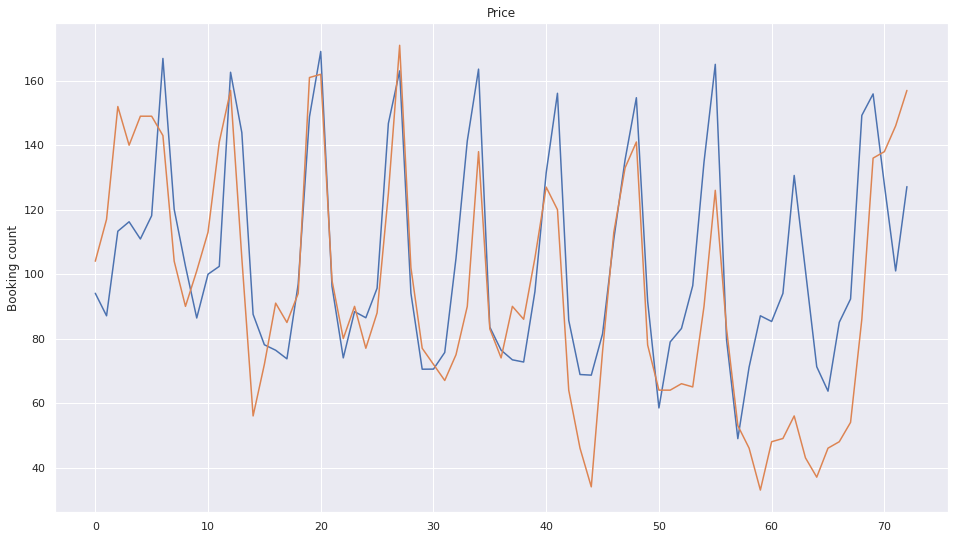

In [46]:
sns.lineplot(x=range(len(y_price_pred)), y=y_bookings_pred)
sns.lineplot(x=range(len(y_price_pred)), y=y_bookings_test)
plt.title('Price')

Text(0.5, 1.0, 'Count')

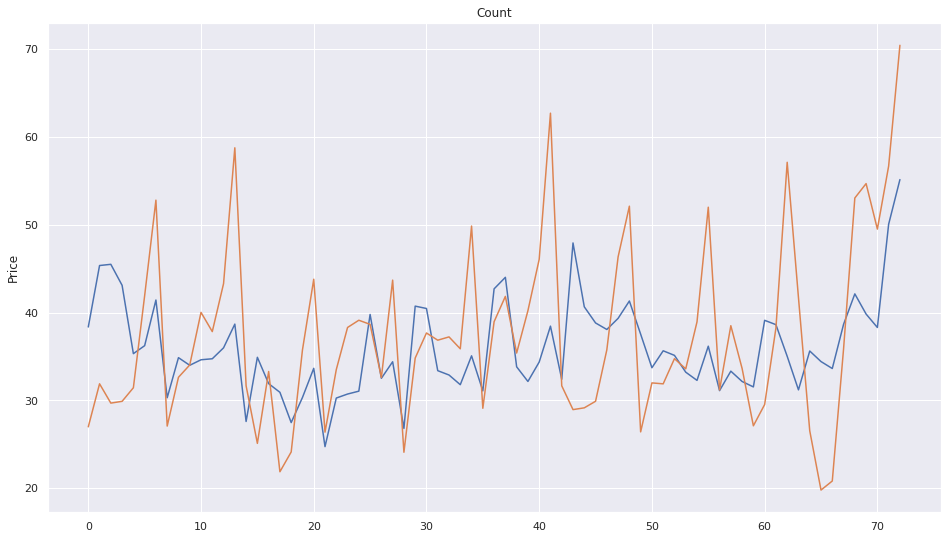

In [47]:
sns.lineplot(x=range(len(y_price_pred)), y=y_price_pred)
sns.lineplot(x=range(len(y_price_pred)), y=y_price_test)
plt.title('Count')

<AxesSubplot:xlabel='importances', ylabel='feature'>

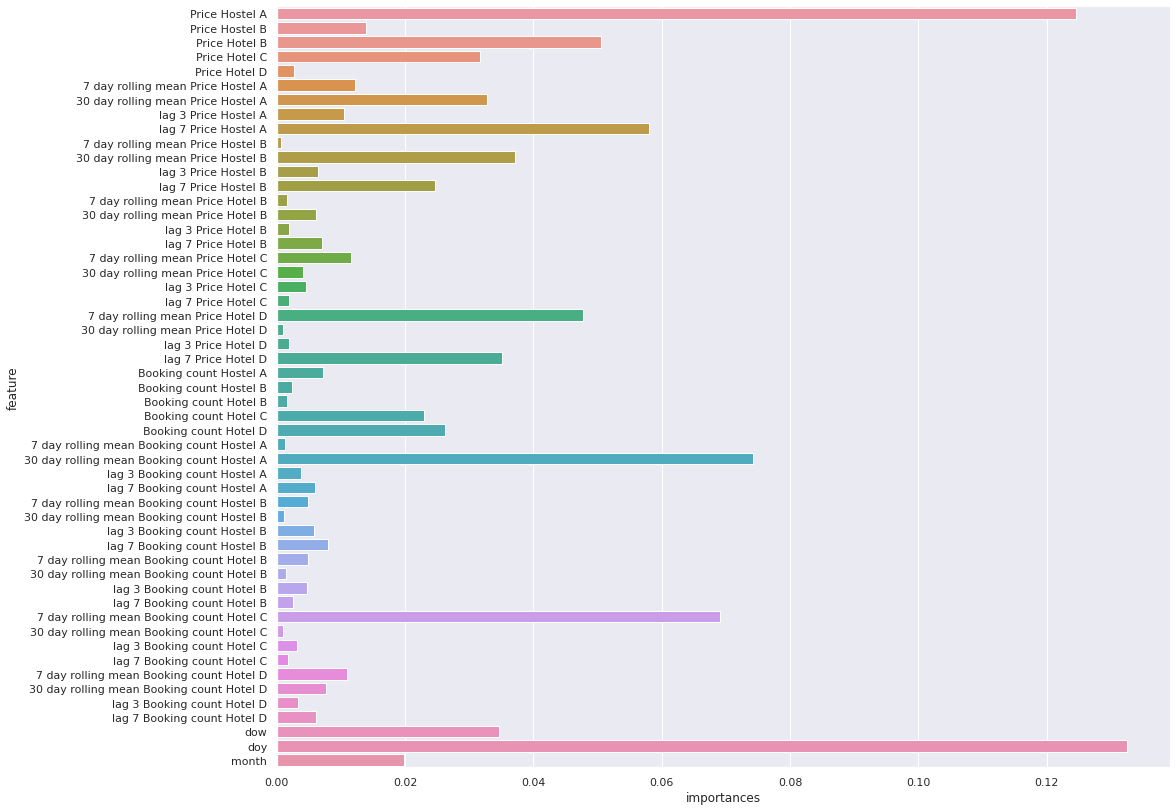

In [48]:
sns.set(rc={'figure.figsize':(16, 14)})
price_importances = pd.DataFrame({'feature': X.columns, 'importances': model_price.feature_importances_})
sns.barplot(data=price_importances, y='feature', x='importances')

<AxesSubplot:xlabel='importances', ylabel='feature'>

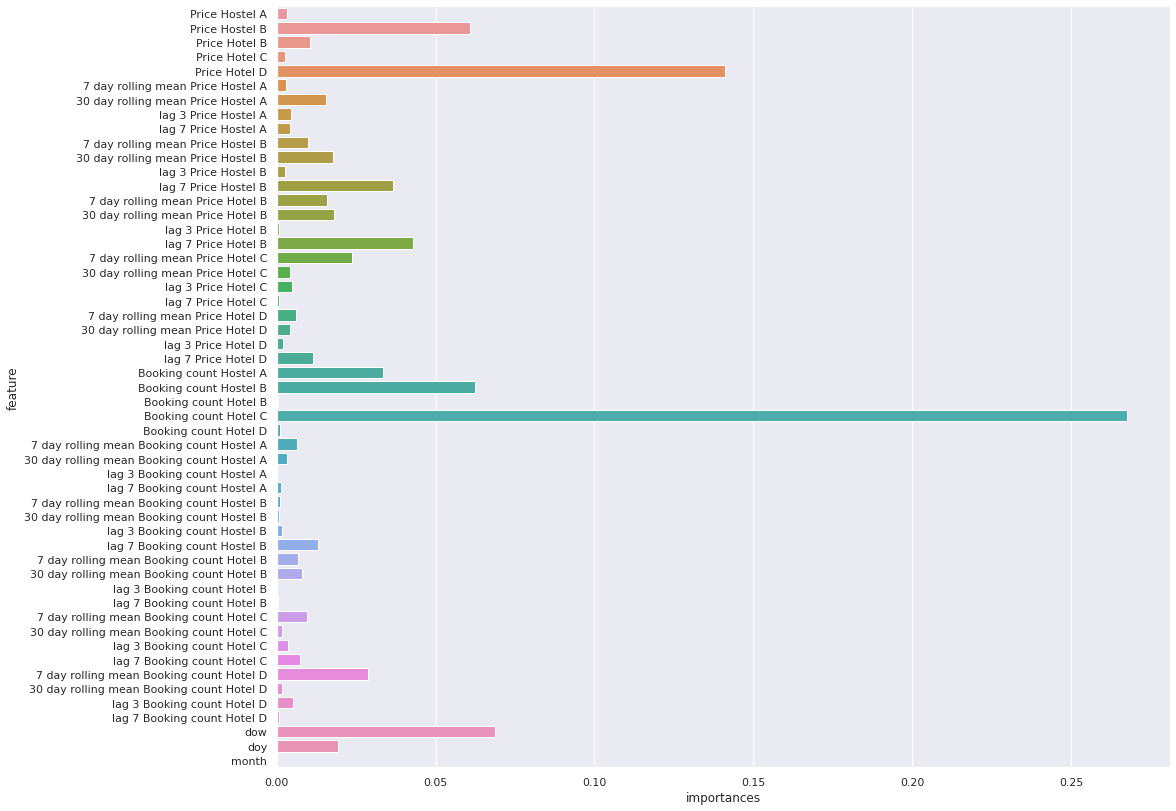

In [49]:
bookings_importances = pd.DataFrame({'feature': X.columns, 'importances': model_bookings.feature_importances_})
sns.barplot(data=bookings_importances, y='feature', x='importances')

We train a model (GBTRegressor) using features of using the prices and counts of the other hotels. Rolling day averages are included as a feature to explain trends. We also include decomposed date features.

Price model does better than the bookings model, it is likely the Hotel A pricing strategy includes similar strategies for seasonality and trend, with feature importances high for price of Hostel A, doy, 30 day rolling mean Hostel A.

For bookings model the seasonality is not correctly learned although the trend seems to follow well. Highest feature importance with Hotel C which agrees with the similarity measure from the previous part of the question.

Lag features are also a consideration to add if more time available. GBT was chosen as is a popular choice for competitions, such as kaggle but other models should be tested and backtested with different date ranges for a thorough search for a better model.